# **Siamese Network for One-Shot Learning**

**import packages**

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import tensorflow as tf
import keras.preprocessing
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Layer
from keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
import seaborn as sns
import pandas as pd
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Data Preperation**

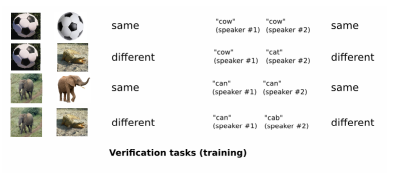

**Details About Same People & Different people in Train & Test Sets.**

In [ ]:
#if you want to run it u should to change this to your folder in drive.
train = open('pairsDevTrain.txt','r').readlines()
test= open('pairsDevTest.txt','r').readlines()
#train and test are lists that the first element is the number of people are the same and the other element are the names of persons' images.
amount_people_diff_train= len(train[1:]) - int(train[0])
amount_people_diff_test=  len(test[1:]) - int(test[0])

print("total samples amount is:" , len(train[1:])+len(test[1:]))
print("The amount of Samples in Train Set : " ,len(train[1:]))
print("The amount of Samples in Test Set : " ,len(test[1:]))
print("The amount of same people in Train Set : ", int(train[0]))
print("The amount of same people in Test Set : ", int(test[0]))
print("The amount of different people in the Training Set :" , amount_people_diff_train)
print("The amount of different people in the Test Set :" , amount_people_diff_test)


total samples amount is: 3200
The amount of Samples in Train Set :  2200
The amount of Samples in Test Set :  1000
The amount of same people in Train Set :  1100
The amount of same people in Test Set :  500
The amount of different people in the Training Set : 1100
The amount of different people in the Test Set : 500


**Dividing To Labels**

In [ ]:
# we will divide to different people and same people label. 0- different . 1- same
train_same=np.array([1]*int(train[0]))
train_difference=np.array([0]*amount_people_diff_train)
test_same_difference=np.array([1]*1000)
test_same_difference[int(test[0]):]=[0]

**Creating a training set and a test set with the complete paths of the**

**images while considering identical and different images**

In [ ]:
train_same=np.array([1]*int(train[0]))
train_difference=np.array([0]*amount_people_diff_train)
folder='DL/'
pair_of_same_train=[]
pair_of_difference_train=[]
lst=[0,0]
alltest=[]
for i in range(len(test[1:])):
  alltest.append(lst)

for i in range(amount_people_diff_train):
  #at the training set from 1100 place we have the same images
  #there are only 3 values at each line: the name and 2 numbers of image. for example: ['Tommy_Robredo', '2', '3']
  train_same_line=train[1:][i].split()

  #at the training set from 0 place to 1100 we have the different images .
  # there are 4 values at each line: name, number of image, different name, number of image. for example:['Abdullah,1,Dwain_Kyles,1]
  train_difference_line=train[1:][i+amount_people_diff_train].split()

  if int(train_same_line[1])>=10:
       zeroes_train='00'
  else:
       zeroes_train='000'
  image_first_difference_train= '/content/drive/MyDrive/'+folder+'lfw2/' + train_difference_line[0] +'/' + train_difference_line[0] + '_' + '000' + train_difference_line[1] + '.jpg'
  image_second_difference_train = '/content/drive/MyDrive/'+folder+'lfw2/' + train_difference_line[2] +'/' + train_difference_line[2] + '_' + '000' + train_difference_line[3] + '.jpg'
  image_first_same_train ='/content/drive/MyDrive/'+folder+'lfw2/' + train_same_line[0] +'/' + train_same_line[0] + '_' + zeroes_train + train_same_line[1] + '.jpg'
  image_second_same_train = '/content/drive/MyDrive/'+folder+'lfw2/' + train_same_line[0] +'/' + train_same_line[0] + '_' + zeroes_train + train_same_line[2] + '.jpg'

  #the size of the test is 500 couples.
  if i<500:
     test_same_line=test[1:][i].split()
     test_difference_line=test[1:][i+amount_people_diff_test].split()

     image_first_difference_test= '/content/drive/MyDrive/'+folder+'lfw2/' + test_difference_line[0] +'/' + test_difference_line[0] + '_' + '000' + test_difference_line[1] + '.jpg'
     image_second_difference_test = '/content/drive/MyDrive/'+folder+'lfw2/' + test_difference_line[2] +'/' + test_difference_line[2] + '_' + '000' + test_difference_line[3] + '.jpg'

     image_first_same_test ='/content/drive/MyDrive/'+folder+'lfw2/' + test_same_line[0] +'/' + test_same_line[0] + '_' + '000' + test_same_line[1] + '.jpg'
     image_second_same_test = '/content/drive/MyDrive/'+folder+'lfw2/' + test_same_line[0] +'/' + test_same_line[0] + '_' + '000' + test_same_line[2] + '.jpg'

     alltest[i]= [image_first_same_test,image_second_same_test]
     alltest[i+amount_people_diff_test]=[image_first_difference_test,image_second_difference_test]

  pair_of_same_train.append([image_first_same_train,image_second_same_train])
  pair_of_difference_train.append( [image_first_difference_train,image_second_difference_train])

**Repair The paths**

in the previous cell some of the paths with double digit or more image were like this: **'/abdullah_00013'.jpg'**.  So I correct this to **'/abdullah_0013.jpg'**

In [ ]:
import re
all_paths=[]
list_train_same_difference_test=[]
lst_datasets=[alltest,pair_of_same_train,pair_of_difference_train]
for dataset in lst_datasets:
  all_paths=[]
  for path1,path2 in dataset:
      lst_numbers=re.findall(r'\d+',str(path1))
      lst_numers2=re.findall(r'\d+',str(path2))
      if int(lst_numbers[1])>=10 and int(lst_numbers[1])<100:
        path1=path1.replace(lst_numbers[1],'00'+str(int(lst_numbers[1])))
      if int(lst_numers2[1])>=10 and int(lst_numers2[1])<100:
        path2=path2.replace(lst_numers2[1],'00'+str(int(lst_numers2[1])))
      if int(lst_numbers[1])>=100:
        path1=path1.replace(lst_numbers[1],'0'+str(int(lst_numbers[1])))
      if int(lst_numers2[1])>=100:
        path2=path2.replace(lst_numers2[1],'0'+str(int(lst_numers2[1])))
      all_paths.append([path1,path2])

  list_train_same_difference_test.append(all_paths)

alltest=list_train_same_difference_test[0]
pair_of_same_train=list_train_same_difference_test[1]
pair_of_difference_train=list_train_same_difference_test[2]

**Train Test- Dividing to Train & Validation Sets**

In [ ]:
x_same_train, x_same_validation, y_same_train, y_same_validation = train_test_split(np.array(pair_of_same_train), train_same, test_size=0.15, random_state=322601907)
x_difference_train, x_difference_validation, y_difference_train, y_difference_validation = train_test_split(np.array(pair_of_difference_train), train_difference, test_size=0.15, random_state=322601907)

**We want to combine same and difference of train & validation sets to one array**

In [ ]:
#concet 2 arrays to one array that the first half rows belongs to pair of same images and the last half rows belongs to pair difference images
train_pairs_same_difference_concat=np.concatenate((x_same_train,x_difference_train), axis=0)
validation_pairs_same_difference_concat=np.concatenate((x_same_validation,x_difference_validation), axis=0)


In [ ]:
#labels
#concet 2 arrays to 1D array that the first half belongs to same labels and the last half difference labels
train_labels_same_difference_concat=np.concatenate((y_same_train, y_difference_train), axis=None)
validation_labels_same_difference_concat=np.concatenate((y_same_validation, y_difference_validation), axis=None)


### **Reading The images from their paths and Preprocessing them**

- decoding the images and normalize them ( 0 to 1).
- create datasets for train,test and validation with the images and their labels

This improves and Optimising input pipeline performance with tf.data .
The tf.data API enables you to build complex input pipelines from simple, reusable pieces. tf.data also makes it possible to handle large amount of data, reading from different data formats, and perform complex transformation

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
def image_preprocess(path_image):
  #reading, decoding and change the size to input image
  img = tf.io.read_file(path_image)
  img = tf.image.decode_jpeg(img, channels=1)
  img = tf.image.resize(img, (105,105))
  img = tf.cast(img/255, tf.float32)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return img

In [ ]:
def read_and_preprocess(path_image_list):
  pair_image1_image2 = ((image_preprocess(path_image_list[0]),image_preprocess(path_image_list[1])))
  return pair_image1_image2

Partition for batches with size of 128 (like the article).

In [ ]:
dataset_of_datasets=[]
lst_tup_pairs_paths_labels= [(train_pairs_same_difference_concat,train_labels_same_difference_concat),(alltest,test_same_difference),(validation_pairs_same_difference_concat,validation_labels_same_difference_concat)]
for i in range(3):

  #from_tensor_slices creates a dataset with a separate element for each row of the input tensor:
  dataset = tf.data.Dataset.from_tensor_slices(lst_tup_pairs_paths_labels[i][0])
  labels_dataset = tf.data.Dataset.from_tensor_slices(lst_tup_pairs_paths_labels[i][1])

  dataset = dataset.map(read_and_preprocess, num_parallel_calls=AUTOTUNE)
  dataset=tf.data.Dataset.zip((dataset, labels_dataset))
  dataset_of_datasets.append(dataset)
  #batch with size of 128
  dataset_of_datasets[i]=dataset_of_datasets[i].repeat(1)
  dataset_of_datasets[i]=dataset_of_datasets[i].batch(128)
  dataset_of_datasets[i]=dataset_of_datasets[i].shuffle(1024)


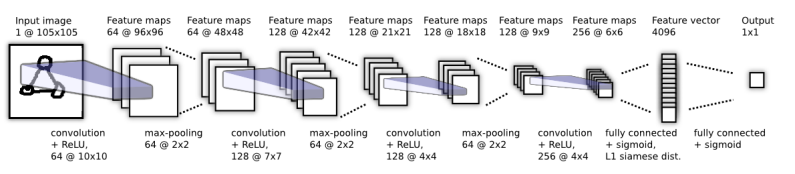

# **Model Implementation**

In [ ]:
def Siamase_model():
    input=Input(shape=(105,105,1),name='input_image')
    #first block
    first_convolution = Conv2D(64,(10,10), activation='relu', kernel_regularizer=l2(0.0001),name='first_convolution')(input)
    batch_normal1=BatchNormalization(name='first_batch')(first_convolution)
    first_maxpool = MaxPooling2D(name='first_maxpool')(batch_normal1)
    dropout1=Dropout(0.1,name='first_dropout')(first_maxpool)

    #second block
    second_convolution = Conv2D(128,(7,7), activation='relu', kernel_regularizer=l2(0.0001),name='second_convolution')(dropout1)
    batch_normal2=BatchNormalization(name='second_batch')(second_convolution)
    second_maxpool = MaxPooling2D(name='second_maxpool')(batch_normal2)
    dropout2=Dropout(0.1,name='second_dropout')(second_maxpool)

    #third block
    third_convolution = Conv2D(128,(4,4), activation='relu', kernel_regularizer=l2(0.0001),name='third_convolution')(dropout2)
    batch_normal3=BatchNormalization(name='third_batch')(third_convolution)
    third_maxpool = MaxPooling2D(name='third_maxpool')(batch_normal3)
    dropout3=Dropout(0.1,name='third_dropout')(third_maxpool)

    #final block (sigmoid)/ The embedding
    fourth_convolution = Conv2D(256,(4,4), activation='relu', kernel_regularizer=l2(0.0001),name='fourth_convolution')(dropout3)
    batch_normal4=BatchNormalization(name='fourth_batch')(fourth_convolution)
    flatten = Flatten(name='flatten_vector')(batch_normal4)
    output = Dense(4096, activation='sigmoid', kernel_regularizer=l2(0.0001),name='output_embedding')(flatten)

    model=Model(inputs=[input],outputs=[output])
    return model

**The Model (like the article)**

In [ ]:
model=Siamase_model()
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 1)]     0         
                                                                 
 first_convolution (Conv2D)  (None, 96, 96, 64)        6464      
                                                                 
 first_batch (BatchNormaliza  (None, 96, 96, 64)       256       
 tion)                                                           
                                                                 
 first_maxpool (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 first_dropout (Dropout)     (None, 48, 48, 64)        0         
                                                                 
 second_convolution (Conv2D)  (None, 42, 42, 128)      4015

In [ ]:
class DistanceLayer(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [ ]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_image', shape=(105,105,1))

    # Validation image in the network
    validation_image = Input(name='validation_image', shape=(105,105,1))

    # Combine siamese distance components
    model=Siamase_model()
    siamese_layer = DistanceLayer()
    siamese_layer._name = 'distance'
    distances = siamese_layer(model(input_image), model(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

summary

In [ ]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 validation_image (InputLayer)  [(None, 105, 105, 1  0           []                               
                                )]                                                                
                                                                                                  
 model_5 (Functional)           (None, 4096)         38949952    ['input_image[0][0]',            
                                                                  'validation_image[0

- loss
- stopping criteria
- optimization

In [ ]:
#loss
binary_cross_loss = tf.losses.BinaryCrossentropy()
#optimization
opt = tf.keras.optimizers.Adam(1e-4)
siamese_model.compile(optimizer=opt, loss=binary_cross_loss,metrics=['binary_accuracy'])
#Number of epochs with no improvement after which training will be stopped.
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

## **Results and Experiments**

In [ ]:
start_time =time.process_time()
performace = siamese_model.fit(dataset_of_datasets[0], epochs=20, validation_data=dataset_of_datasets[2],callbacks=[callback])
end_time = time.process_time()

# prediction.(array with probabilities)
pred = siamese_model.predict(dataset_of_datasets[1])

#processing time
print("The model process time (convergence) is:",end_time-start_time)



Epoch 1/20
15/15 [==============================] - 11s 374ms/step - loss: 1.3736 - binary_accuracy: 0.4604 - val_loss: 1.2958 - val_binary_accuracy: 0.5212
Epoch 2/20
15/15 [==============================] - 9s 357ms/step - loss: 1.1542 - binary_accuracy: 0.7476 - val_loss: 1.2919 - val_binary_accuracy: 0.5455
Epoch 3/20
15/15 [==============================] - 10s 364ms/step - loss: 1.0336 - binary_accuracy: 0.8524 - val_loss: 1.2876 - val_binary_accuracy: 0.6152
Epoch 4/20
15/15 [==============================] - 11s 372ms/step - loss: 0.9366 - binary_accuracy: 0.9160 - val_loss: 1.2828 - val_binary_accuracy: 0.5818
Epoch 5/20
15/15 [==============================] - 10s 365ms/step - loss: 0.8709 - binary_accuracy: 0.9476 - val_loss: 1.2777 - val_binary_accuracy: 0.6182
Epoch 6/20
15/15 [==============================] - 11s 374ms/step - loss: 0.8148 - binary_accuracy: 0.9749 - val_loss: 1.2703 - val_binary_accuracy: 0.6061
Epoch 7/20
15/15 [==============================] - 10s 373

**Test Loss and Accuracy**

In [ ]:
loss_accuracy_test = siamese_model.evaluate(dataset_of_datasets[1])
print('Loss and accuracy results of test set:')
print(loss_accuracy_test)

8/8 [==============================] - 3s 108ms/step - loss: 1.1145 - binary_accuracy: 0.7060
Loss and accuracy results of test set:
[1.11449134349823, 0.7059999704360962]


In [ ]:
acc_loss=pd.DataFrame({'num of epochs':range(20),"Model's loss":performace.performace['loss'],'validation loss':performace.performace['val_loss'],
              "Model's accuracy":performace.performace['binary_accuracy'],'validation accuracy':performace.performace['val_binary_accuracy']})

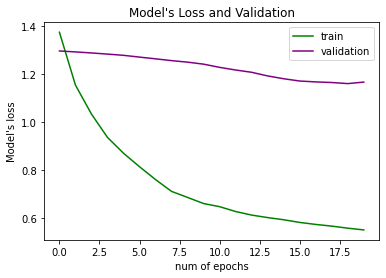

In [ ]:
import seaborn as sns
sns.lineplot(data=acc_loss, x="num of epochs", y="Model's loss",color='green').set(title="Model's Loss and Validation")
sns.lineplot(data=acc_loss, x="num of epochs", y="validation loss",color='purple')
plt.legend(['train', 'validation'], loc='upper right')

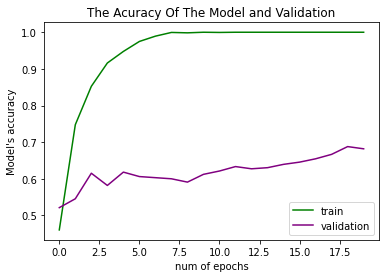

In [ ]:
sns.lineplot(data=acc_loss, x="num of epochs", y="Model's accuracy",color='green').set(title='The Acuracy Of The Model and Validation')
sns.lineplot(data=acc_loss, x="num of epochs", y="validation accuracy",color='purple')
plt.legend(['train', 'validation'], loc='lower right')

**Showing the changing of performance of test set**

* We wrote the answers after each experiment (We did a screen shots of a lot of experiments with different parameters so we take only the relevantic from them).

In [ ]:
lst_x=['SGD','ADAM','BN','BN+DROPOUT-0.1','BN+DROPOUT-0.5']
lst_loss=[1.12,1.06,0.969,0.908,0.8448]
lst_accuracy=[0.55,0.645, 0.688, 0.72, 0.774]
df_test=pd.DataFrame({'experiments':lst_x,'loss':lst_loss,"accuracy":lst_accuracy})


[Text(0.5, 1.0, 'The Accuracy Of Test Set')]

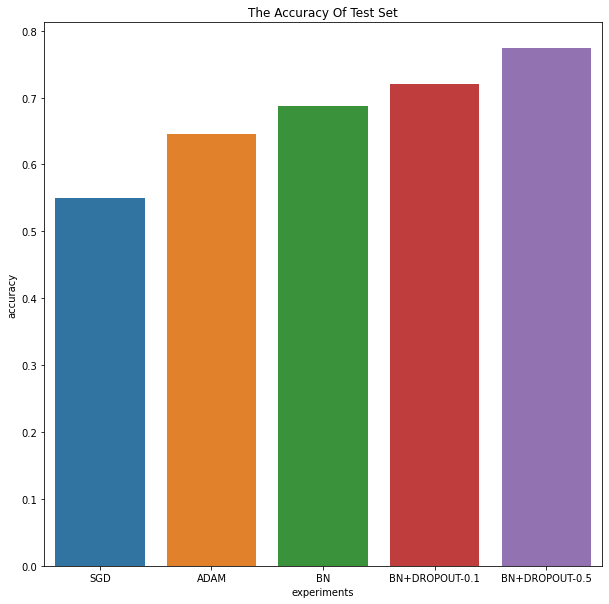

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(data=df_test,x='experiments', y='accuracy',ax=ax).set(title='The Accuracy Of Test Set')
